In [1]:
from util import *

import pandas as pd
import numpy as np 

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from xgboost import plot_importance

In [2]:
df = pd.read_csv('preprocess_data.csv')
df

,title,year,rating,runtime,kind,color_info,sound_mix,director_name,genre,director_id,cast_names,cast_ids,votes,country,day,month
0,Miss Jerry,1894,5.9,40.0,movie,Black and White,Silent,['Alexander Black'],"['Short', 'Romance']",['0085156'],"['0063086', '0183823', '1309758']","['0063086', '0183823', '1309758']",191.0,USA,0,8.0
1,The Story of the Kelly Gang,1906,6.1,70.0,movie,Black and White,Silent,['Charles Tait'],"['Action', 'Adventure', 'Biography', 'Crime', ...",['0846879'],"['0846887', '0846894', '1431224', '3002376', '...","['0846887', '0846894', '1431224', '3002376', '...",737.0,Australia,26,12.0
2,Den sorte drøm,1911,5.9,53.0,movie,Black and White,Silent,['Urban Gad'],['Drama'],['0300487'],"['0003425', '0699637', '0375839', '0016799', '...","['0003425', '0699637', '0375839', '0016799', '...",218.0,Germany,19,8.0
3,Cleopatra,1963,7.0,192.0,movie,Color,DTS,['Joseph L. Mankiewicz'],"['Biography', 'Drama', 'History', 'Romance']",['0000581'],"['0000072', '0000009', '0001322', '0114386', '...","['0000072', '0000009', '0001322', '0114386', '...",31526.0,Canada,31,7.0
4,Torment,1994,7.1,102.0,movie,Color,Dolby,['Claude Chabrol'],"['Crime', 'Drama', 'Thriller']",['0001031'],"['0000322', '0167388', '0136597', '0932870', '...","['0000322', '0167388', '0136597', '0932870', '...",4936.0,France,16,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1990,Resurrection,2001,6.9,187.0,tv movie,Color,Others,"['Paolo Taviani', 'Vittorio Taviani']","['Drama', 'History']","['0851752', '0851754']","['0733625', '0668742', '0126669', '0092291', '...","['0733625', '0668742', '0126669', '0092291', '...",214.0,France,26,12.0
1991,We're Not Dressing,1934,6.1,74.0,movie,Black and White,Mono,['Norman Taurog'],"['Comedy', 'Musical']",['0851537'],"['0001078', '0001479', '0122675', '0020555', '...","['0001078', '0001479', '0122675', '0020555', '...",775.0,USA,27,3.0
1992,We're Rich Again,1934,6.4,71.0,movie,Black and White,Mono,['William A. Seiter'],['Comedy'],['0782682'],"['0646829', '0000992', '0633260', '0219666', '...","['0646829', '0000992', '0633260', '0219666', '...",230.0,USA,13,7.0
1993,Family Life,1971,7.6,108.0,movie,Color,Mono,['Ken Loach'],['Drama'],['0516360'],"['0711605', '0212674', '0147016', '0862939', '...","['0711605', '0212674', '0147016', '0862939', '...",1597.0,Ireland,18,2.0


In [3]:
df['year'].value_counts()

1934    211
1933    207
1932    207
1931    163
1930    130
       ... 
1906      1
1964      1
1971      1
1976      1
1894      1
Name: year, Length: 111, dtype: int64

# Feature Engineering


In [4]:
# age là tuổi của phim được cho đến năm hiện tại (2021)
df['age'] = 2021 - df['year']
df['age']

0       127
1       115
2       110
3        58
4        27
       ... 
1990     20
1991     87
1992     87
1993     50
1994     87
Name: age, Length: 1995, dtype: int64

In [5]:
df = df.dropna(subset = ['cast_names','cast_ids','director_name','director_id'])

In [6]:
df['cast_ids']

0                       ['0063086', '0183823', '1309758']
1       ['0846887', '0846894', '1431224', '3002376', '...
2       ['0003425', '0699637', '0375839', '0016799', '...
3       ['0000072', '0000009', '0001322', '0114386', '...
4       ['0000322', '0167388', '0136597', '0932870', '...
                              ...                        
1990    ['0733625', '0668742', '0126669', '0092291', '...
1991    ['0001078', '0001479', '0122675', '0020555', '...
1992    ['0646829', '0000992', '0633260', '0219666', '...
1993    ['0711605', '0212674', '0147016', '0862939', '...
1994    ['0000078', '0265551', '0371025', '0926103', '...
Name: cast_ids, Length: 1945, dtype: object

In [7]:
# tách 1 chuỗi string thành mảng các string chứa thông tin
df['cast_names'] = df['cast_names'].apply(split_text)
df['cast_ids'] = df['cast_ids'].apply(split_text)
df['director_name'] = df['director_name'].apply(split_text)


<ipython-input-7-57ad34609bf1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cast_names'] = df['cast_names'].apply(split_text)
<ipython-input-7-57ad34609bf1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cast_ids'] = df['cast_ids'].apply(split_text)
<ipython-input-7-57ad34609bf1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

In [8]:
#number cast là số lượng thành viên đoàn cast
df['number_cast'] = df['cast_names'].apply(lambda s: len(s))
df['number_cast']

<ipython-input-8-e1e3e1ee3d5f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['number_cast'] = df['cast_names'].apply(lambda s: len(s))


0        3
1       17
2       11
3       85
4       27
        ..
1990    50
1991    25
1992    23
1993    35
1994    16
Name: number_cast, Length: 1945, dtype: int64

In [9]:
le = preprocessing.LabelEncoder()
df['country'] = le.fit_transform(df['country'])
df['country'] 

<ipython-input-9-d2f5b57e34a6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['country'] = le.fit_transform(df['country'])


0       49
1        1
2       20
3        7
4       19
        ..
1990    19
1991    49
1992    49
1993    25
1994    49
Name: country, Length: 1945, dtype: int32

In [10]:
le = preprocessing.LabelEncoder()
df['country'] = le.fit_transform(df['country'])
df['kind'] = le.fit_transform(df['kind'])
df['color_info'] = le.fit_transform(df['color_info'])
df['sound_mix'] = le.fit_transform(df['sound_mix'])


<ipython-input-10-0757d77adb3a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['country'] = le.fit_transform(df['country'])
<ipython-input-10-0757d77adb3a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['kind'] = le.fit_transform(df['kind'])
<ipython-input-10-0757d77adb3a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

In [11]:
df = df.reset_index(drop = True)
X = df.drop(['rating'], axis = 1)
y = df['rating']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.1, random_state = 1)

In [13]:
X_train = X_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

In [14]:
# xây dựng dict chứa thông tin về điểm trung bình của đạo diễn và các diễn viên
cast_score_board = getScoreBroad(X_train['cast_ids'], y_train)
director_score_board = getScoreBroad(X_train['director_id'], y_train)

Xây dựng dict bằng tập train và sau đó mapping sang tập test

In [15]:
for i in X_train.index:
    s = df['cast_ids'][i]
    me, ma, mi = getScore(s, cast_score_board)
    X_train.loc[i,'cast_mean_score'] = me
    X_train.loc[i,'cast_max_score'] = ma
    X_train.loc[i,'cast_min_score'] = mi
    
    s = df.loc[i,'director_id']
    me, ma, mi = getScore(s, director_score_board)
    X_train.loc[i,'director_mean_score'] = me
    X_train.loc[i,'director_max_score'] = ma
    X_train.loc[i,'director_min_score'] = mi

    
for i in X_test.index:
    s = df['cast_ids'][i]
    me, ma, mi = getScore(s, cast_score_board)
    X_test.loc[i,'cast_mean_score'] = me
    X_test.loc[i,'cast_max_score'] = ma
    X_test.loc[i,'cast_min_score'] = mi
    
    s = df['director_id'][i]
    me, ma, mi = getScore(s, director_score_board)
    X_test.loc[i,'director_mean_score'] = me
    X_test.loc[i,'director_max_score'] = ma
    X_test.loc[i,'director_min_score'] = mi

# Visualize 


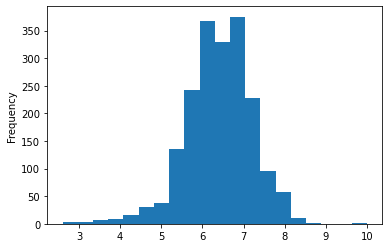

In [16]:
df.rating.plot.hist(bins = 20);

phân bố của rating tập trung chủ yếu ở 6 đến 7 điểm 

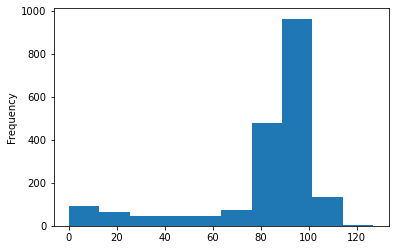

In [17]:
df.age.plot.hist();

Số lượng phim tập trung vào 20 năm đổ lại

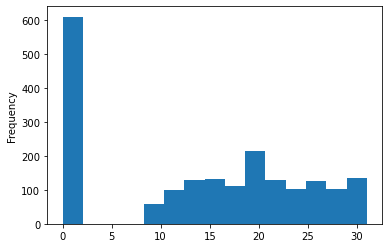

In [18]:
df.day.plot.hist(bins = 15);

Phim chủ yếu được release vào cuối tháng, tập trung chủ yếu vào ngày 19 đến 20

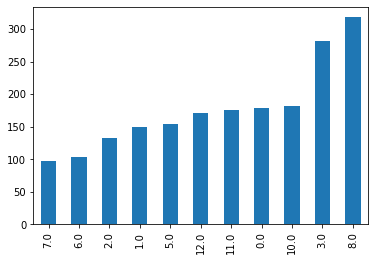

In [19]:
df.month.value_counts().sort_values().plot.bar(); 

Phim được phát hành tập trung vào các tháng đầu và cuối năm

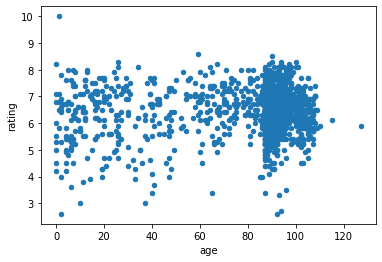

In [20]:
df.plot.scatter(x='age', y='rating');

Có thể dễ dàng thấy được số lượng phim có tuổi đời lớn hơn 70 có rating cao hơn và số lượng ít hơn.

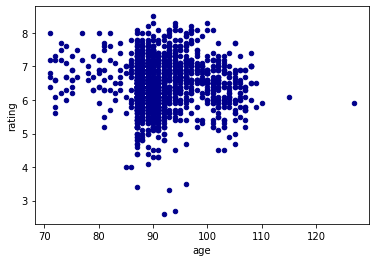

In [21]:
case = df[df['age']>70]
case.plot.scatter(x='age', y='rating', c='DarkBlue');

In [22]:
print('Rating trung bình của các bộ phim có tuổi đời lớn hơn 70:',round(case.rating.mean(),3))
print('Rating trung bình của tất cả phim:',round(df.rating.mean(),3))

Rating trung bình của các bộ phim có tuổi đời lớn hơn 70: 6.438
Rating trung bình của tất cả phim: 6.416


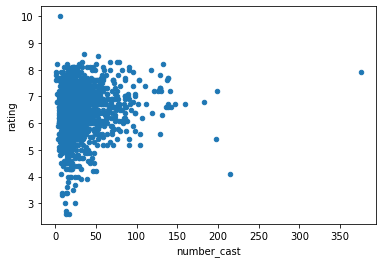

In [23]:
df.plot.scatter(x= 'number_cast', y='rating');

Với number cast lớn thì phim có xu hướng điểm cao hơn

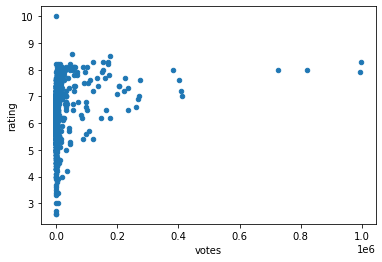

In [24]:
df.plot.scatter(x= 'votes', y='rating');

Số vote càng cao thì tỉ lệ rate càng cao

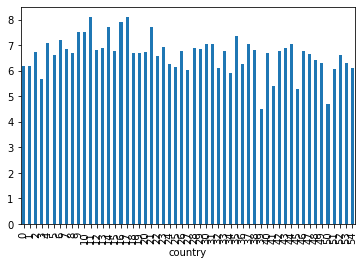

In [25]:
df.groupby('country').rating.mean().plot.bar();

Rating trung bình phim của các nước không cách biệt nhau quá nhiều

# Train Model


In [26]:
select_feature = ['year', 'runtime', 'kind', 'color_info', 'sound_mix','votes',
                  'country', 'day', 'month', 'age', 'number_cast',
                  'cast_mean_score', 'cast_max_score', 'cast_min_score',
                  'director_mean_score', 'director_max_score', 'director_min_score']

In [27]:
X_train = X_train[select_feature]
X_test = X_test[select_feature]

evalset = [(X_train, y_train), (X_test,y_test)]

In [28]:
model = XGBRegressor(n_estimators = 500,
                     max_depth=3);
model.fit(X_train,y_train, eval_metric='rmse', eval_set=evalset);

[0]	validation_0-rmse:4.21346	validation_1-rmse:4.20217
[1]	validation_0-rmse:2.99113	validation_1-rmse:2.98871
[2]	validation_0-rmse:2.14660	validation_1-rmse:2.15507
[3]	validation_0-rmse:1.56998	validation_1-rmse:1.58991
[4]	validation_0-rmse:1.18491	validation_1-rmse:1.22890
[5]	validation_0-rmse:0.93676	validation_1-rmse:1.00053
[6]	validation_0-rmse:0.78232	validation_1-rmse:0.87775
[7]	validation_0-rmse:0.69320	validation_1-rmse:0.80716
[8]	validation_0-rmse:0.63951	validation_1-rmse:0.77223
[9]	validation_0-rmse:0.61099	validation_1-rmse:0.75773
[10]	validation_0-rmse:0.59095	validation_1-rmse:0.74849
[11]	validation_0-rmse:0.58159	validation_1-rmse:0.74574
[12]	validation_0-rmse:0.57324	validation_1-rmse:0.74012
[13]	validation_0-rmse:0.56915	validation_1-rmse:0.73705
[14]	validation_0-rmse:0.56543	validation_1-rmse:0.73820
[15]	validation_0-rmse:0.55874	validation_1-rmse:0.73774
[16]	validation_0-rmse:0.55458	validation_1-rmse:0.73706
[17]	validation_0-rmse:0.54977	validation

[144]	validation_0-rmse:0.35458	validation_1-rmse:0.73863
[145]	validation_0-rmse:0.35316	validation_1-rmse:0.73718
[146]	validation_0-rmse:0.35218	validation_1-rmse:0.73677
[147]	validation_0-rmse:0.35147	validation_1-rmse:0.73756
[148]	validation_0-rmse:0.35048	validation_1-rmse:0.73741
[149]	validation_0-rmse:0.34887	validation_1-rmse:0.73737
[150]	validation_0-rmse:0.34793	validation_1-rmse:0.73843
[151]	validation_0-rmse:0.34625	validation_1-rmse:0.73963
[152]	validation_0-rmse:0.34505	validation_1-rmse:0.74192
[153]	validation_0-rmse:0.34391	validation_1-rmse:0.74251
[154]	validation_0-rmse:0.34256	validation_1-rmse:0.74094
[155]	validation_0-rmse:0.34162	validation_1-rmse:0.74208
[156]	validation_0-rmse:0.34115	validation_1-rmse:0.74223
[157]	validation_0-rmse:0.34018	validation_1-rmse:0.74286
[158]	validation_0-rmse:0.33884	validation_1-rmse:0.74261
[159]	validation_0-rmse:0.33789	validation_1-rmse:0.74272
[160]	validation_0-rmse:0.33747	validation_1-rmse:0.74369
[161]	validati

[286]	validation_0-rmse:0.25235	validation_1-rmse:0.75237
[287]	validation_0-rmse:0.25150	validation_1-rmse:0.75280
[288]	validation_0-rmse:0.25114	validation_1-rmse:0.75287
[289]	validation_0-rmse:0.25055	validation_1-rmse:0.75307
[290]	validation_0-rmse:0.25002	validation_1-rmse:0.75339
[291]	validation_0-rmse:0.24949	validation_1-rmse:0.75320
[292]	validation_0-rmse:0.24885	validation_1-rmse:0.75267
[293]	validation_0-rmse:0.24870	validation_1-rmse:0.75285
[294]	validation_0-rmse:0.24820	validation_1-rmse:0.75279
[295]	validation_0-rmse:0.24745	validation_1-rmse:0.75292
[296]	validation_0-rmse:0.24656	validation_1-rmse:0.75394
[297]	validation_0-rmse:0.24611	validation_1-rmse:0.75371
[298]	validation_0-rmse:0.24539	validation_1-rmse:0.75326
[299]	validation_0-rmse:0.24484	validation_1-rmse:0.75282
[300]	validation_0-rmse:0.24404	validation_1-rmse:0.75294
[301]	validation_0-rmse:0.24330	validation_1-rmse:0.75278
[302]	validation_0-rmse:0.24264	validation_1-rmse:0.75275
[303]	validati

[428]	validation_0-rmse:0.18628	validation_1-rmse:0.76272
[429]	validation_0-rmse:0.18595	validation_1-rmse:0.76277
[430]	validation_0-rmse:0.18539	validation_1-rmse:0.76283
[431]	validation_0-rmse:0.18485	validation_1-rmse:0.76338
[432]	validation_0-rmse:0.18421	validation_1-rmse:0.76341
[433]	validation_0-rmse:0.18399	validation_1-rmse:0.76358
[434]	validation_0-rmse:0.18361	validation_1-rmse:0.76406
[435]	validation_0-rmse:0.18302	validation_1-rmse:0.76451
[436]	validation_0-rmse:0.18279	validation_1-rmse:0.76496
[437]	validation_0-rmse:0.18266	validation_1-rmse:0.76518
[438]	validation_0-rmse:0.18258	validation_1-rmse:0.76519
[439]	validation_0-rmse:0.18224	validation_1-rmse:0.76509
[440]	validation_0-rmse:0.18170	validation_1-rmse:0.76423
[441]	validation_0-rmse:0.18160	validation_1-rmse:0.76406
[442]	validation_0-rmse:0.18121	validation_1-rmse:0.76382
[443]	validation_0-rmse:0.18087	validation_1-rmse:0.76337
[444]	validation_0-rmse:0.18059	validation_1-rmse:0.76307
[445]	validati

# Evaluation


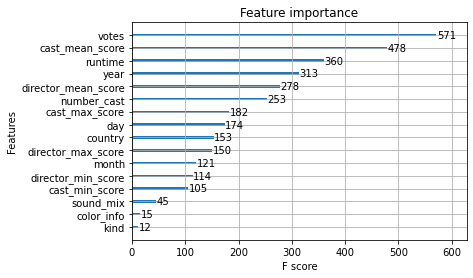

In [29]:
plot_importance(model)
pyplot.show()

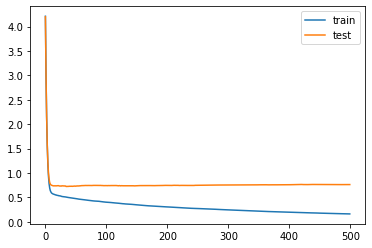

In [30]:
results = model.evals_result()
pyplot.plot(results['validation_0']['rmse'], label='train')
pyplot.plot(results['validation_1']['rmse'], label='test')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()